# Prediction Model 

Kelun Chai

1. Prophet
2. Arima
3. LSTM

## Data Preperation

In [1]:
# import plotly.offline as py
# import plotly.express as px
#from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pred = pd.read_csv("covid-19-all.csv")
pred = pred.fillna(0)
# pred.head()

In [3]:
predgrp = pred[pred['Country/Region']=='France'].groupby('Date')['Confirmed','Recovered','Deaths'].sum().reset_index()
# predgrp.head(7)

In [4]:
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
# pred_cnfrm.head()

In [5]:
pr_data = pred_cnfrm
pr_data.columns = ['ds','y']
pr_data.tail()

,ds,y
118,2020-05-21,181951.0
119,2020-05-22,182015.0
120,2020-05-23,182036.0
121,2020-05-24,182709.0
122,2020-05-25,183067.0


## Prophet

In [24]:
from fbprophet import Prophet
m=Prophet()
m.fit(pr_data)
future=m.make_future_dataframe(periods=30)
forecast=m.predict(future)
# forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Prediction for next 15 days

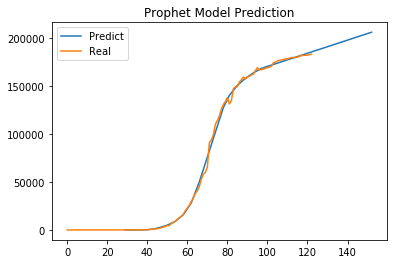

In [45]:
f_data = forecast.loc[:,['ds','trend']]
# Prenez que les bonnes prédictions(trend>0)
predict = f_data[f_data['trend']>0].rename(columns={"ds":"Date","trend":"Confirm"})
predict[["Confirm"]] = predict[["Confirm"]].astype(int)
plt.plot(predict["Confirm"],label="Predict")
plt.plot(pr_data["y"],label="Real")
plt.title("Prophet Model Prediction")
plt.legend()
plt.show()

## Arima

In [6]:
from statsmodels.tsa.arima_model import ARIMA, ARMA

$y_t=c+\phi_1y_{t-1}+\phi_2y_{t-2}+...+\phi_py_{t-p}+\varepsilon_t$

$c:valeur\ initiale, \phi:Autocorrélation$

$E_{\varepsilon_t}=0, Var(\varepsilon_t)=\sigma^2_\varepsilon,E(\varepsilon_t\varepsilon_s)=0,\varepsilon_t\neq\varepsilon_s$

$Y_t=\epsilon_t+\beta Y_{t-1}-\beta^2Y_{t-2}+\beta^3Y_{t-3}-\beta^4Y_{t-4}+...$

$Y_t=\epsilon_t+\beta\epsilon_{t-1}$

In [7]:
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]

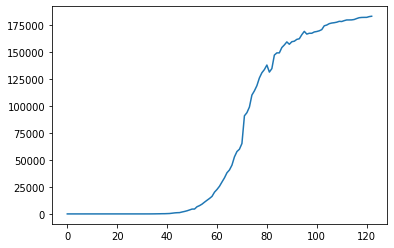

In [8]:
plt.plot(pred_cnfrm["Confirmed"].values)
plt.show()

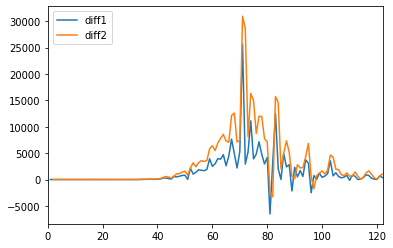

In [12]:

pred_cnfrm["diff1"]=pred_cnfrm["Confirmed"]-pred_cnfrm["Confirmed"].shift(1)
pred_cnfrm["diff2"]=pred_cnfrm["Confirmed"]-pred_cnfrm["Confirmed"].shift(2)
#pred_cnfrm["Confirmed"].plot(label="nodiff")
pred_cnfrm["diff1"].plot(label="diff1")
pred_cnfrm["diff2"].plot(label="diff2")
plt.legend(loc='upper left')
#from statsmodels.graphics.tsaplots import plot_pacf
#plot_pacf(pred_cnfrm["diff2"]).show()

$d=0, y_t=Y_t$

$
d=1,y_t=Y_t-Y_{t-1}
$

$
d=2,
y_t = (Y_t - Y_{t-1})-(Y_{t-1}-Y_{t-2})
$

In [36]:
from statsmodels.tsa.stattools import adfuller as ADF
print("Original ADF Results：\n",ADF(arima_data['count']))
print("Diff1 ADF Results：\n",ADF(ts_diff1(arima_data['count'])))
print("Diff2 ADF Results：\n",ADF(ts_diff2(arima_data['count'])))

NameError: name 'arima_data' is not defined

In [37]:
def draw_ar(ts, w):
    arma = ARMA(ts, order=(w,0)).fit(disp=-1)
    ts_predict = arma.predict()

    plt.clf()
    plt.plot(ts_predict, label="PDT")
    plt.plot(ts, label = "ORG")
    plt.legend(loc="best")
    plt.title("AR Test %s" % w)

In [38]:
confirm_cs = pred_cnfrm.cumsum()
confirm_cs['date1'] = pred_cnfrm['Date']
confirm_cs = confirm_cs.drop('Date',axis=1)
arima_data = confirm_cs
arima_data.columns = ['count','confirmed_date']

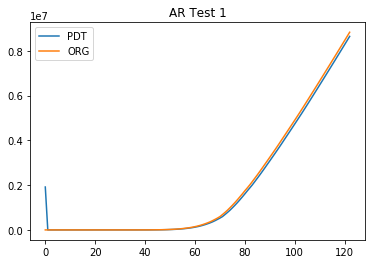

In [39]:
draw_ar(np.asarray(arima_data['count']),1)

In [40]:
model = ARIMA(arima_data['count'].values, order=(2, 2, 1))
fit_model = model.fit(trend='c', full_output=True, disp=True)
#fit_model.summary()

In [41]:
forcast = fit_model.forecast(steps=30)
pred_y = forcast[0].tolist()
pred = pd.DataFrame(pred_y)
pred['pred']=  pred - pred.shift(1)
predict = pd.DataFrame({'Date':pd.date_range("20200526",periods=29).astype(str),'Confirmed':pred.drop(0)['pred'].astype(int)})
print(predict.head())
pred_cnfrm["Confirmed"] = pred_cnfrm["Confirmed"].astype(int)
print(pred_cnfrm.head())

         Date  Confirmed
1  2020-05-26     184209
2  2020-05-27     184820
3  2020-05-28     185460
4  2020-05-29     186129
5  2020-05-30     186823
         Date  Confirmed
0  2020-01-24          2
1  2020-01-25          3
2  2020-01-26          3
3  2020-01-27          3
4  2020-01-28          4


In [42]:
res = pd.concat([pred_cnfrm, predict])
res.reset_index(drop=True,inplace=True)

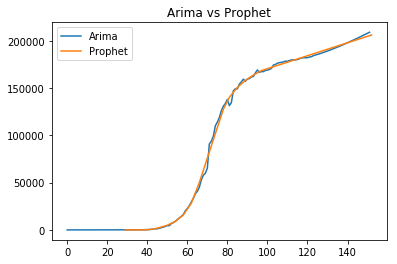

In [47]:
plt.plot(res["Confirmed"],label="Arima")
#plt.plot(pred_cnfrm["Confirmed"],label="Real")
plt.plot(predict["Confirm"],label="Prophet")
plt.legend()
plt.title("Arima vs Prophet")
plt.show()

In [121]:
res = res.to_json(orient='records')

In [114]:
dataset_c = pd.DataFrame(pred_cnfrm['Confirmed'])

In [115]:
data = np.array(dataset_c).reshape(-1, 1)
train_data = dataset_c[:len(dataset_c)-8]
test_data = dataset_c[len(dataset_c)-8:]
test_data

,Confirmed
115,180051
116,180933
117,181700
118,181951
119,182015
120,182036
121,182709
122,183067


## LSTM

In [97]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [98]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
n_input =5
n_features =1
                             
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data, length=n_input, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm_model.fit(generator, epochs = 8)

Epoch 1/8
110/110 [==============================] - 1s 8ms/step - loss: 0.0650
Epoch 2/8
110/110 [==============================] - 1s 6ms/step - loss: 0.0088
Epoch 3/8
110/110 [==============================] - 1s 6ms/step - loss: 0.0067
Epoch 4/8
110/110 [==============================] - 1s 7ms/step - loss: 0.0080
Epoch 5/8
110/110 [==============================] - 1s 6ms/step - loss: 0.0052
Epoch 6/8
110/110 [==============================] - 1s 6ms/step - loss: 0.0046
Epoch 7/8
110/110 [==============================] - 1s 6ms/step - loss: 0.0045
Epoch 8/8
110/110 [==============================] - 1s 6ms/step - loss: 0.0041


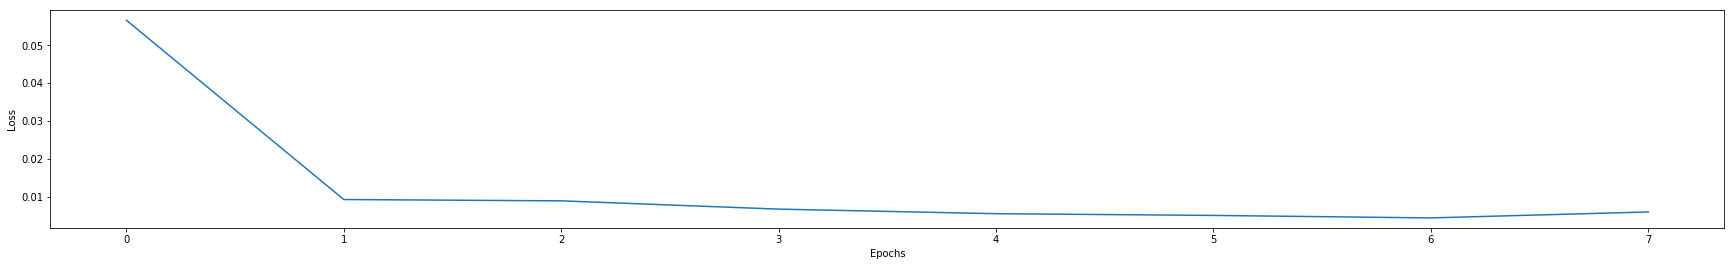

In [18]:
import matplotlib.pyplot as plt
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize = (30,4))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,100,1))
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.show()

In [99]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
prediction

,0
0,174661.781039
1,174854.172282
2,174817.617624
3,174466.101698
4,173838.460480
5,172826.336668
6,172801.574181
7,172664.491538


## Fit with sigmoid

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Any results you write to the current directory are saved as output.
train=pd.read_csv('covid-19-all.csv')
train.fillna(0)
train.head(10)

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
0,China,Anhui,31.8257,117.2264,1.0,NaN,NaN,2020-01-22
1,China,Beijing,40.1824,116.4142,14.0,NaN,NaN,2020-01-22
2,China,Chongqing,30.0572,107.8740,6.0,NaN,NaN,2020-01-22
3,China,Fujian,26.0789,117.9874,1.0,NaN,NaN,2020-01-22
4,China,Gansu,37.8099,101.0583,NaN,NaN,NaN,2020-01-22
5,China,Guangdong,23.3417,113.4244,26.0,NaN,NaN,2020-01-22
6,China,Guangxi,23.8298,108.7881,2.0,NaN,NaN,2020-01-22
7,China,Guizhou,26.8154,106.8748,1.0,NaN,NaN,2020-01-22
8,China,Hainan,19.1959,109.7453,4.0,NaN,NaN,2020-01-22
9,China,Hebei,39.5490,116.1306,1.0,NaN,NaN,2020-01-22


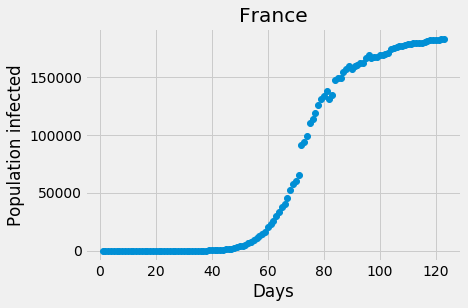

In [21]:
country_df = train[train['Country/Region']=='France'].groupby('Date')['Confirmed','Deaths'].sum()
country_df['day_count'] = list(range(1,len(country_df)+1))
ydata = country_df.Confirmed
xdata = country_df.day_count
country_df['rate'] = (country_df.Confirmed-country_df.Confirmed.shift(1))/country_df.Confirmed
country_df['increase'] = (country_df.Confirmed-country_df.Confirmed.shift(1))

plt.plot(xdata, ydata, 'o')
plt.title("France")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

[92.63362386  1.75222064  4.22892906]


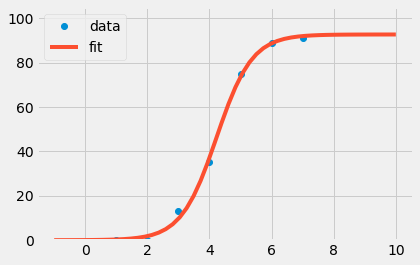

In [22]:
from scipy.optimize import curve_fit
import pylab


def sigmoid(x,c,a,b):
     y = c*1 / (1 + np.exp(-a*(x-b)))
     return y
#country_df.ConfirmedCases
#country_df.day_count
xdata = np.array([1, 2, 3,4, 5, 6, 7])
ydata = np.array([0, 0, 13, 35, 75, 89, 91])

#([low_a,low_b],[high_a,high_b])
#low x --> low b
#high y --> high c
#a is the sigmoidal shape.
popt, pcov = curve_fit(sigmoid, xdata, ydata, method='dogbox',bounds=([0.,0., 0.],[100,2, 10.]))
print(popt)

x = np.linspace(-1, 10, 50)
y = sigmoid(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(-0.05, 105)
pylab.legend(loc='best')
pylab.show()

In [23]:
in_df = train[train['Country/Region']=='France'].groupby('Date')['Confirmed','Deaths','Recovered'].sum().reset_index(False)
in_df['Active']=in_df['Confirmed']-in_df['Deaths']-in_df['Recovered']
in_df = in_df[in_df.Active>=100]

In [24]:
import pylab
from datetime import timedelta

in_df['day_count'] = list(range(1,len(in_df)+1))
in_df['increase'] = (in_df.Active-in_df.Active.shift(1))
in_df['rate'] = (in_df.Active-in_df.Active.shift(1))/in_df.Active


def sigmoid(x,c,a,b):
     y = c*1 / (1 + np.exp(-a*(x-b)))
     return y

xdata = np.array(list(in_df.day_count)[::2])
ydata = np.array(list(in_df.Active)[::2])

population=1.332*10**9
popt, pcov = curve_fit(sigmoid, xdata, ydata, method='dogbox',bounds=([0.,0., 0.],[population,6, 100.]))
print(popt)

[9.39416648e+04 2.15689871e-01 3.16315125e+01]


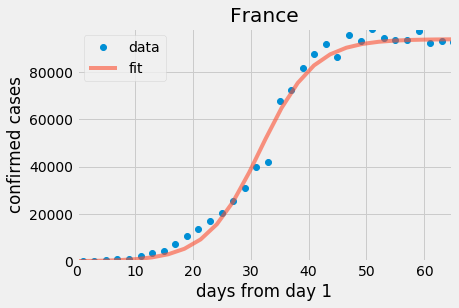

model fitted max Active at: 93941
model sigmoidal coefficient is: 0.216
model curve stop steepening, start flattening by day: 31
model curve flattens by day: 62


,Date,Confirmed,Deaths,Recovered,Active,day_count,increase,rate
37,2020-03-01,130.0,2.0,12.0,116.0,1,NaN,NaN
38,2020-03-02,191.0,3.0,12.0,176.0,2,60.0,0.340909
39,2020-03-03,204.0,4.0,12.0,188.0,3,12.0,0.063830


,Date,Confirmed,Deaths,Recovered,Active,day_count,increase,rate
120,2020-05-23,182036.0,28218.0,63988.0,89830.0,84,19.0,0.000212
121,2020-05-24,182709.0,28370.0,64735.0,89604.0,85,-226.0,-0.002522
122,2020-05-25,183067.0,28460.0,65317.0,89290.0,86,-314.0,-0.003517


In [25]:
est_a = popt[0]
est_b = popt[1]
est_c = popt[2]
x = np.linspace(-1, in_df.day_count.max()+50, 50)
y = sigmoid(x,est_a,est_b,est_c)
pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit',alpha = 0.6)
pylab.ylim(-0.05, est_a*1.05)
pylab.xlim(-0.05, est_c*2.05)
pylab.legend(loc='best')
plt.xlabel('days from day 1')
plt.ylabel('confirmed cases')
plt.title('France')
pylab.show()


#print('model start date:',in_df[in_df.day_count==1].index[0])
#print('model start infection:',int(in_df[in_df.day_count==1].Active[0]))
print('model fitted max Active at:',int(est_a))
print('model sigmoidal coefficient is:',round(est_b,3))
print('model curve stop steepening, start flattening by day:',int(est_c))
print('model curve flattens by day:',int(est_c)*2)
display(in_df.head(3))
display(in_df.tail(3))